# Implementing framework for training neural networks
In this project I developed a simple framework for training deep neural networks consisting of a bunch of sequential layers. It's only dependency is numpy - a python library for matrix operations and tqdm for progress bars. Below I will present how it works.

## Math
The goal is to construct a function $f(x)$, that takes a vector $x$ and makes a best prediction of $y$ based on data we have. In deep learning this function is a neural network.

The main building blocks of any neural networks are **layers** - the way of transforming one representation of data into the next one. There are two things we need to specify for each layer: how many neurons the output vector has and the activation function $g$. This is described by a following equation:
$$ a^{[l+1]} =  g(W^{[l+1]} a^{[l+1]}) $$. 
In this equation $l$ is a number of layer, $a$s are vectors, $W$ a matrix of appropriate dimensionality and $g$ is a pointwise function.

At the end of computations we obtain our output $\hat{y}$. In order for the network to work, we need to specify the loss function based on a true value of $y$.

## API
* `NeuralNetwork` - a class representing neural network. It is initalized with:
    * input_size: int - size of an input vector
    * layers: Iterable[Layer] - List of tuples representing consecutive layers with (number of neurons, activation function)
    * loss - loss function
    
    It's main method is `fit`(x, y, [n_iter, lr]) which finds optimal parameters of the network.
    
* `nnet.activations` - includes various classes representing activation functions, deriving from base Activation. Each of them has to implement two methods: forward and backward 
* `nnet.losses` - includes various classes representing loss functions, deriving from base Loss. Each of them has to implement two methods: forward and backward

## Demo
Let's see how it works.

In [1]:
from nnet import NeuralNetwork
from nnet.activations import Sigmoid, Identity
from nnet.losses import QuadraticLoss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")
import seaborn as sns

First let's generate some data and build a simple linear neural network (with no hidden layers). It's only layer is output layer with one dimensional output.

In [2]:
def add_one_feature(x):
    """Transforimng input matrix to have a feature consisting of all ones."""
    assert len(x.shape) == 2
    n = x.shape[1]
    return np.vstack([x, np.ones([1, n])])

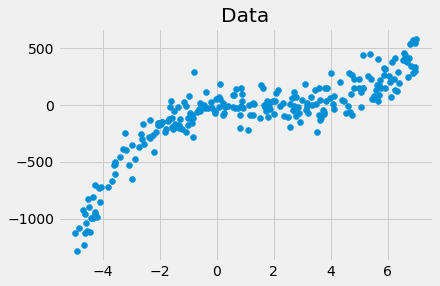

Shape of x_train: (2, 250), shape of y_train: (1, 250)


In [3]:
n = 250
data = pd.read_csv("data/regression/data.cube.test.100.csv").sample(n)
data["y"] = data["y"] + np.random.normal(0, 100, [n])
plt.scatter(data.x, data.y)
plt.title("Data")
plt.show()

x_train = add_one_feature(data.x.values.reshape(1, -1))
y_train = data.y.values.reshape(1, -1)
print("Shape of x_train: {}, shape of y_train: {}".format(x_train.shape, y_train.shape))

100%|██████████| 1000/1000 [00:00<00:00, 29206.41it/s]

Training completed. Loss: 31883.112517581023


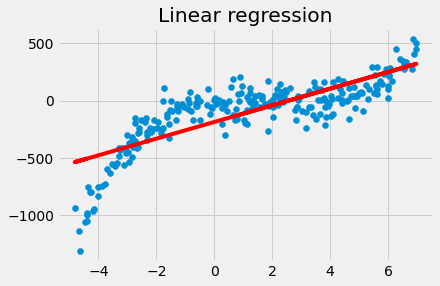

In [4]:
net = NeuralNetwork(2, [(1, Identity())], QuadraticLoss(), sd=1e-3)
net.fit(x_train, y_train, n_iter=1000, lr=0.01)

y_pred = net(x_train)
plt.scatter(data.x, data.y)
plt.plot(data.x, y_pred.reshape(-1), color="red")
plt.title("Linear regression");

We see, that it's a simple line. This is because this model is a linear regression model - there are no hidden layers so the output is a linear combination of input features ($a*x + b$ in this case). Let's try to make this prediction better by adding nonlinear layers.

In [5]:
def train_net_and_plot(net, x, y, title, **kwargs):
    net.fit(x, y, **kwargs)
    # Plotting
    points = np.linspace(min(data.x), max(data.x), 1000)
    y_pred = net(add_one_feature(points.reshape(1, -1)))
    plt.scatter(data.x, data.y)
    plt.plot(points, y_pred.reshape(-1), color="red")
    plt.title(title)

100%|██████████| 1000/1000 [00:00<00:00, 4278.17it/s]


Training completed. Loss: 32373.673902260296


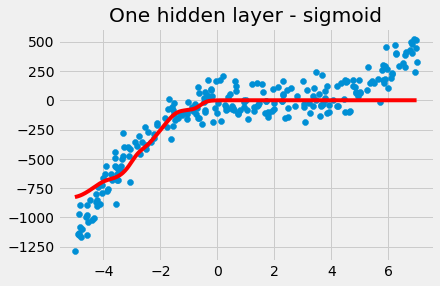

In [21]:
net = NeuralNetwork(2, [(10, Sigmoid()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "One hidden layer - sigmoid")

We see a clear improvement in the capacity of the network to capture more complicated shapes. Here we can also observe that changing **learning rate** can influence the quality of the model.

100%|██████████| 1000/1000 [00:00<00:00, 4352.75it/s]


Training completed. Loss: 29609.1457345888


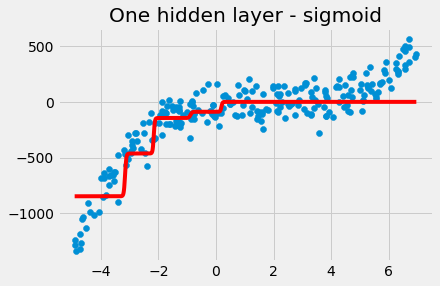

In [8]:
net = NeuralNetwork(2, [(10, Sigmoid()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "One hidden layer - sigmoid", lr=0.01)

Function above doesn't seem to be the best fit to the data and is a little bit weird. This can be attributed to the fact that we are using **sigmoid** activation function. When values get too low or too large it essentialy is a step function 0 if a value is low, 1 if large. Thus, hidden state after being activated is a bunch of ones and zeros. We then take a linear combination of such ones and zeros and get a weird shaped function as above. I printed these states below to show that it's indeed the case.

In [8]:
net.a_states[1]

array([[1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        1.29691546e-256, 4.72945557e-257, 1.72468836e-257],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        1.53713912e-261, 5.48757962e-262, 1.95906341e-262],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        3.89809793e-257, 1.41759935e-257, 5.15530385e-258],
       ...,
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        2.81766206e-270, 1.34525478e-270, 6.42273766e-271],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        2.93412741e-221, 1.31673515e-221, 5.90905309e-222],
       [1.00000000e+000, 1.00000000e+000, 1.00000000e+000, ...,
        4.83735758e-247, 1.89162527e-247, 7.39710908e-248]])

Finally, let's train more powerful network.

100%|██████████| 100000/100000 [00:40<00:00, 2467.67it/s]


Training completed. Loss: 95622.02306247872


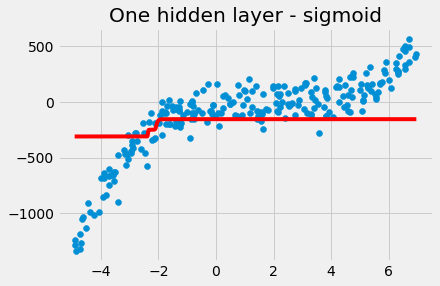

In [10]:
net = NeuralNetwork(2, [(10, Sigmoid()), (10, Sigmoid()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "Two hidden layers - sigmoid", lr=1e-3, n_iter=100_000)

It's even worse. If we increase the number of hidden layers of neurons in theory the network has better capacity, but we probably encounter optimization problems here. Either the number of iterations is too low, or we get stuck in local minima. From my quick experiments, I would speculate that it's the latter - increasing number of iterations even $10$ times doesn't change much.

We saw that sigmoid is not necessarily the best activatoin function: first because it can quickly become a step function, second becaues for large values it's gradient becomes zero, it would be interesting to test other activation functions. Implementing them in this framework is simple: we create a class that inherits from base Activation class and implement forward and backward methods. Forward method is a simple computation that takes a vector and returns activation function from that vector. Backward is a derivative of that function. Both functions should be pointwise and return vectors of the same shape.

Relu is defined as $Relu(x) = \max(0, x)$, that is it's $x$ for $x \geq 0$ and $0$ otherwise. Because of that the gradient is $1$ for $x > 0$ and $0$ otherwise and  implementation is as follows:
```
class Relu(Activation):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.where(x >= 0, x, 0)

    def backward(self, x: np.ndarray) -> np.ndarray:
        return np.where(x >= 0, 1, 0)
```
Now we can use it as an activation function in our framework.

100%|██████████| 50000/50000 [00:04<00:00, 10603.68it/s]


Training completed. Loss: 120321.19609623027


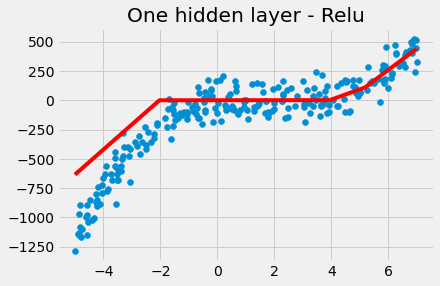

In [15]:
from nnet.activations import Relu

np.random.seed(42)
net = NeuralNetwork(2, [(15, Relu()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "One hidden layer - Relu", lr=1e-3, n_iter=50_000)

We clearly see different shapes of the function that can be attributed to the Relu activation function. Now, let's try to **decrease learning rate**.

100%|██████████| 50000/50000 [00:04<00:00, 10522.10it/s]


Training completed. Loss: 9027.41261432322


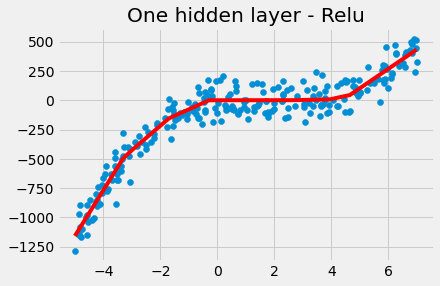

In [16]:
np.random.seed(42)
net = NeuralNetwork(2, [(15, Relu()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "One hidden layer - Relu", lr=1e-4, n_iter=50_000)

All of the sudden it works beautifully!

For comparison the same network with sigmoid activation function: it can learn the function at the beginning quite well, but ending is far from perfect unfortunately. That's because the final predictions are a linear combination of previous layer. If the activation there is simgoid, all values are between $0$ and $1$. That means, that it's difficult to obtain large values from them - unless the parameters of the last matrix are quite large. Even for a large number of iterations I couldn't make it work. Also, note that even for the same number of iterations ($50 000$) relu fits in $4$ seconds compared to $10$ seconds for Simoid (which has to compute more complicated exponential functions).

100%|██████████| 400000/400000 [01:27<00:00, 4553.47it/s]


Training completed. Loss: 17937.98039000403


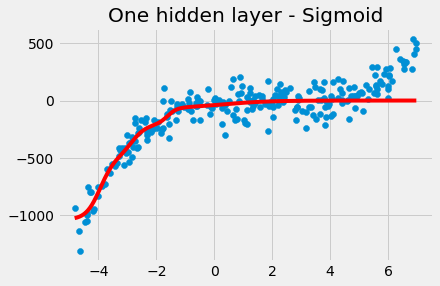

In [8]:
np.random.seed(42)
net = NeuralNetwork(2, [(15, Sigmoid()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "One hidden layer - Sigmoid", lr=1e-4, n_iter=50_000);

After that, adding more hidden layers or neurons doesn't improve performance of the network by very much (networks with sigmoid activations are even worse). Here, we see slight improvement ($8727$ MSE instead of $9027$).

100%|██████████| 50000/50000 [00:09<00:00, 5309.10it/s]


Training completed. Loss: 8723.051404652842


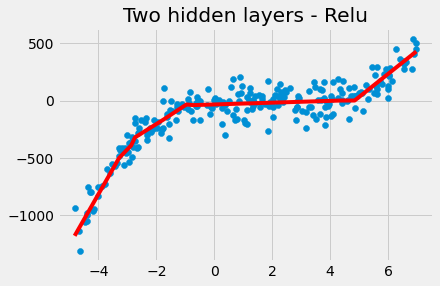

In [12]:
np.random.seed(42)
net = NeuralNetwork(2, [(15, Relu()), (15, Relu()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "Two hidden layers - Relu", lr=1e-4, n_iter=50_000)

Larger networks are harder to train, and take even more time and iterations but do not work better (especially for such simple problems) because of the difficulty with optimization, even for huge number of iterations.

100%|██████████| 500000/500000 [01:31<00:00, 5479.88it/s]


Training completed. Loss: 97685.01018160158


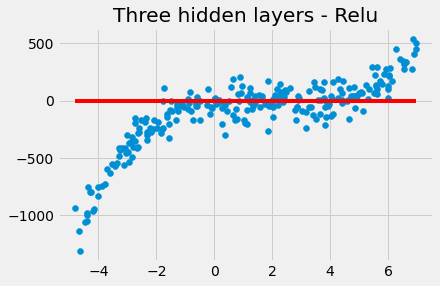

In [16]:
np.random.seed(42)
net = NeuralNetwork(2, [(10, Relu()), (9, Relu()), (8, Relu()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "Three hidden layers - Relu", lr=1e-4, n_iter=500_000)

## Another dataset and various activation functions
One more test on another dataset.

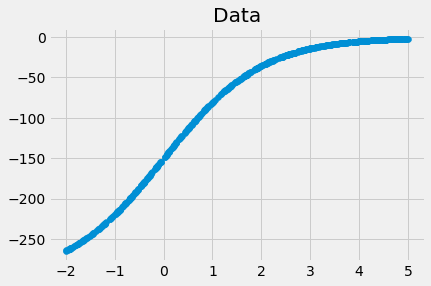

Shape of x_train: (2, 500), shape of y_train: (1, 500)


In [4]:
data = pd.read_csv("data/regression/data.activation.train.500.csv")
data.head()

plt.scatter(data.x, data.y)
plt.title("Data")
plt.show()

x_train = add_one_feature(data.x.values.reshape(1, -1))
y_train = data.y.values.reshape(1, -1)
print("Shape of x_train: {}, shape of y_train: {}".format(x_train.shape, y_train.shape))

In [5]:
def train_net_and_plot(net, x, y, title, **kwargs):
    net.fit(x, y, **kwargs)
    # Plotting
    points = np.linspace(min(data.x), max(data.x), 1000)
    y_pred = net(add_one_feature(points.reshape(1, -1)))
    plt.scatter(data.x, data.y)
    plt.plot(points, y_pred.reshape(-1), color="red")
    plt.title(title)

### Relu 

100%|██████████| 10000/10000 [00:01<00:00, 9341.20it/s]


Training completed. Loss: 13.498816164127835


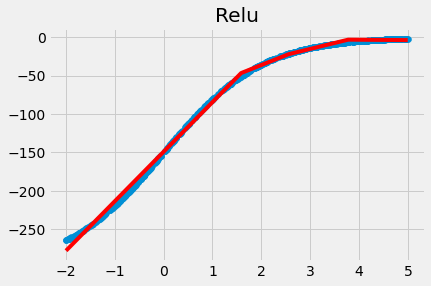

In [7]:
from nnet.activations import Relu
net = NeuralNetwork(2, [(10, Relu()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "Relu", n_iter=10_000, lr=0.001)

### Leaky Relu

100%|██████████| 20000/20000 [00:02<00:00, 9140.51it/s]


Training completed. Loss: 12.820640551087523


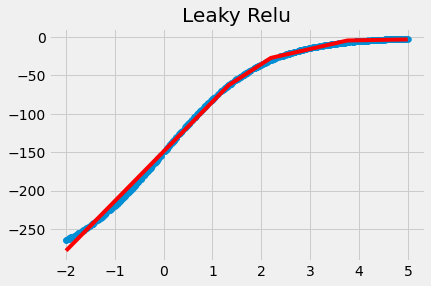

In [8]:
from nnet.activations import LeakyRelu
net = NeuralNetwork(2, [(10, LeakyRelu()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "Leaky Relu", n_iter=20_000, lr=0.001)

### Hyperbolic Tangent

100%|██████████| 20000/20000 [00:08<00:00, 2294.44it/s]


Training completed. Loss: 0.09498830981539778


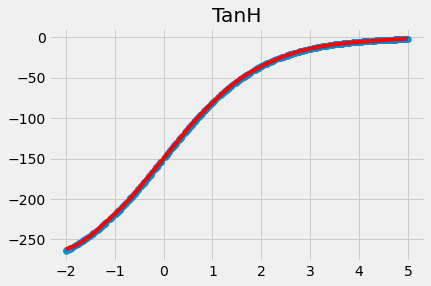

In [9]:
from nnet.activations import TanH
net = NeuralNetwork(2, [(10, TanH()), (1, Identity())], QuadraticLoss(), sd=1e-3)
train_net_and_plot(net, x_train, y_train, "TanH", n_iter=20_000, lr=0.001)

## Summary
I implemented and tested my framework for training neural networks for simple regression problem. I visualized and measured performance of various architectures. It turns out, that Relu activation outperforms Sigmoid. Not only it works better for regression, it is also simpler and thus over twice as fast.

As for my python package, it turned out that I can easily extend it with other activation functions and loss functions and implement multiple sequential architectures. Implementing it gave me deeper understanding how backpropagation works and that helped with reasoning about the performance of the network.